In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The Data Sets are 800mb and cant be uploaded to the GA github

# Things to do

1. Drop all rows with movieId from the movies & ratings dataFrame that do not have metadata
2. The split and break the genres from the movies dataframe into 'dummy' variables (do not drop first) 
3. Find the new distribution of user rating count
4. Start content based filtering model (see powerpoint: the concept for model 1)

# Risks and Assumptions 
1. We're ignoring the whole 'cold start' for the time being
2. We are also ignoring implicit ratings (i.e. assuming the user will rate everything they see)
3. Droping the movies without genome data might make things really bad. like what if most of the ratings were from movies not in the genome set.
4. We are building the model that will have to dynamically fit and predict with user input. How much processing power is each one going to take? Is this even feasible?

In [3]:
df_gs = pd.read_csv('genome-scores.csv')

In [3]:
df_gs.shape

(11709768, 3)

In [4]:
df_gs.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [5]:
df_gs['relevance'].describe()

count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

### so each tag is rated on a scale of 1 to almost 0
### 10,381 movies, each movie has 1128 predictors

In [ ]:
df_gs.groupby('movieId')['movieId'].count()

In [4]:
movies = pd.read_csv('movies.csv')

In [8]:
movies.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [9]:
movies.shape

(27278, 3)

In [5]:
ratings = pd.read_csv('ratings.csv')

In [11]:
ratings.shape

(20000263, 4)

In [12]:
ratings.head(20)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


## Ratings are on a scale of  .5 to 5 .... and values of .5 increments
## 138,493 users rated 26,744 movies
## 20+M ratings in the matrix (20,000,263)

### All users have rated at least 20 movies
### only 10,381 movies have meta data


In [13]:
ratings['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### users tend to like (3+ ratings) the movies they watch

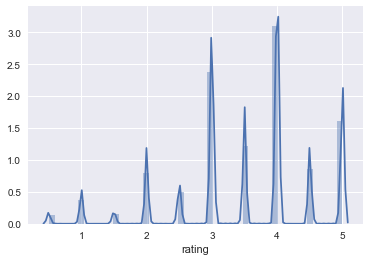

In [14]:
sns.distplot(ratings['rating'])

### The plan is to get a list of the movieIds from the genome set then drop the row in the ratings set if the movieId isn't in the genome list

In [10]:
new_df = df_gs.groupby('movieId')[['movieId']].count()

In [13]:
new_df.columns = ['dropmelater']

In [15]:
new_df.reset_index(inplace=True)

In [43]:
new_df.head()

,movieId,dropmelater
0,1,1128
1,2,1128
2,3,1128
3,4,1128
4,5,1128


In [35]:
new_df.shape

(10381, 2)

In [45]:
new_df.dtypes

movieId        int64
dropmelater    int64
dtype: object

In [46]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [50]:
ratings_updated = ratings.join(new_df.set_index('movieId'), on='movieId', how='left', rsuffix='_drop_me_too')

In [51]:
ratings_updated.head()

,userId,movieId,rating,timestamp,dropmelater
0,1,2,3.5,1112486027,1128.0
1,1,29,3.5,1112484676,1128.0
2,1,32,3.5,1112484819,1128.0
3,1,47,3.5,1112484727,1128.0
4,1,50,3.5,1112484580,1128.0


In [52]:
ratings_updated.isnull().sum()

userId              0
movieId             0
rating              0
timestamp           0
dropmelater    199820
dtype: int64

In [53]:
ratings_updated.dropna(axis=0, inplace=True)

In [54]:
ratings_updated.shape

(19800443, 5)

In [55]:
ratings_updated.head()

,userId,movieId,rating,timestamp,dropmelater
0,1,2,3.5,1112486027,1128.0
1,1,29,3.5,1112484676,1128.0
2,1,32,3.5,1112484819,1128.0
3,1,47,3.5,1112484727,1128.0
4,1,50,3.5,1112484580,1128.0


In [56]:
ratings_updated.drop('dropmelater', axis=1, inplace=True)

In [57]:
ratings_updated.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [58]:
ratings_updated.to_csv('ratings_updated.csv') #oops, forget to set_index to false and this takes a while

### Finally! what happened to the userId Rating count?

In [59]:
ratings_updated.groupby('userId')[['userId']].count()['userId'].describe()

count    138493.000000
mean        142.970713
std         222.220455
min          13.000000
25%          34.000000
50%          67.000000
75%         154.000000
max        6590.000000
Name: userId, dtype: float64

In [61]:
movies_updated = movies.join(new_df.set_index('movieId'), on='movieId', how='left')

In [63]:
movies_updated.isnull().sum()

movieId            0
title              0
genres             0
dropmelater    16897
dtype: int64

In [65]:
movies_updated.shape

(27278, 4)

In [66]:
movies_updated.dropna(axis=0, inplace=True)

In [69]:
movies_updated.drop('dropmelater', axis=1, inplace=True)

#### now to fix the Genre stuff

In [ ]:
#  movies_updated['genres'].value_counts() 

In [94]:
### https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
## This splits/dummies the strings in the genre column
dummies = pd.get_dummies(movies_updated['genres'])

atom_col = [c for c in dummies.columns if '|' not in c]

for col in atom_col:
    movies_updated[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)

In [97]:
movies_updated.columns

Index(['movieId', 'title', 'genres', '(no genres listed)', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [101]:
movies_updated.drop('genres',axis=1, inplace=True)

In [103]:
movies_updated.loc[movies_updated['(no genres listed)'] ==1]

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
24801,117192,Doctor Who: The Time of the Doctor (2013),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 'Adventure | Drama | Family | Mystery | Sci-Fi'

In [107]:
movies_updated.loc[24801, 'Adventure'] = 1
movies_updated.loc[24801, 'Drama'] = 1
movies_updated.loc[24801, 'Mystery'] = 1
movies_updated.loc[24801, 'Sci-Fi'] = 1

In [108]:
movies_updated.loc[24801]

movieId                                                  117192
title                 Doctor Who: The Time of the Doctor (2013)
(no genres listed)                                            1
Action                                                        0
Adventure                                                     1
Animation                                                     0
Children                                                      0
Comedy                                                        0
Crime                                                         0
Documentary                                                   0
Drama                                                         1
Fantasy                                                       0
Film-Noir                                                     0
Horror                                                        0
Musical                                                       0
Mystery                                 

In [109]:
movies_updated.drop('(no genres listed)', axis=1, inplace=True)

In [110]:
movies_updated.columns

Index(['movieId', 'title', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [111]:
movies_updated.to_csv('movies_updated.csv', index=False)

In [112]:
movies_updated.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
users = ratings_updated.groupby('userId')[['userId']].count()

In [128]:
users.columns = ['rated_count']

In [131]:
ratings_updated.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [134]:
users = users.join(ratings_updated.groupby('userId')[['rating']].mean())

In [135]:
users.sort_values('rated_count', inplace=True)

In [137]:
users.columns = ['rated_count', 'avg_rating']

In [138]:
users.reset_index(inplace=True)

In [139]:
users.shape

(138493, 3)

In [140]:
users.head()

,userId,rated_count,avg_rating
0,129562,13,2.692308
1,65137,13,3.961538
2,11415,14,3.214286
3,136748,14,3.714286
4,59147,14,4.464286


In [142]:
users.to_csv('users.csv', index=False)

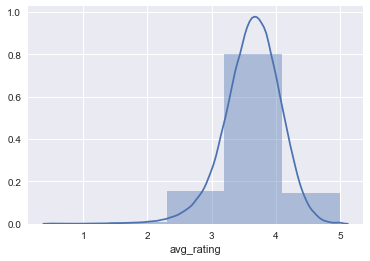

In [144]:
sns.distplot(users['avg_rating'], bins=5)